# PinSage
PinSage는 Pinterest에서 개발한, 그래프 합성곱 네트워크(Graph Convolutional Network, GCN) 기반의 추천 시스템입니다. 이 시스템은 사용자와 아이템(핀) 간의 상호작용과 아이템의 특성을 고려하여 핀에 대한 사용자 선호도를 예측합니다. 기존 GCN에 비해, PinSage는 랜덤 워크에 기반한 보다 효율적인 합성곱 연산을 수행하며, 모델의 강건성과 수렴을 높이기 위해 점진적으로 어려운 학습 샘플로 학습하는 독특한 전략을 도입하였습니다.

PinSage는 Pinterest의 실제 서비스에 적용된 모델로, 그 데이터는 공개되어 있지 않습니다. 그러므로 이 notebook에서는 Deep Graph Library(dgl)에 공개된 예제를 정리하였습니다.

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Preprocess

In [2]:
import argparse
import os
import pickle
import re

import numpy as np
import pandas as pd
import scipy.sparse as ssp
import torch
import torchtext
from builder import PandasGraphBuilder
from data_utils import *

import dgl

In [3]:
directory = "ml-1m"
out_directory = "data"

os.makedirs(out_directory, exist_ok=True)

### Build Heterogeneous Graph

**Users**

In [4]:
users = []
with open(os.path.join(directory, "users.dat"), encoding="latin1") as f:
    for l in f:
        id_, gender, age, occupation, zip_ = l.strip().split("::")
        users.append(
            {
                "user_id": int(id_),
                "gender": gender,
                "age": age,
                "occupation": occupation,
                "zip": zip_,
            }
        )
users = pd.DataFrame(users).astype("category")

users.head()

,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


**Movies**

In [5]:
movies = []
with open(os.path.join(directory, "movies.dat"), encoding="latin1") as f:
    for l in f:
        id_, title, genres = l.strip().split("::")
        genres_set = set(genres.split("|"))

        # extract year
        assert re.match(r".*\([0-9]{4}\)$", title)
        year = title[-5:-1]
        title = title[:-6].strip()

        data = {"movie_id": int(id_), "title": title, "year": year}
        for g in genres_set:
            data[g] = True
        movies.append(data)
        
movies = pd.DataFrame(movies).astype({"year": "category"})

movies.head()

,movie_id,title,year,Children's,Comedy,Animation,Adventure,Fantasy,Romance,Drama,...,Thriller,Action,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
0,1,Toy Story,1995,True,True,True,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Jumanji,1995,True,NaN,NaN,True,True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Grumpier Old Men,1995,NaN,True,NaN,NaN,NaN,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Waiting to Exhale,1995,NaN,True,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Father of the Bride Part II,1995,NaN,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Generes
movies.columns

Index(['movie_id', 'title', 'year', 'Children's', 'Comedy', 'Animation',
       'Adventure', 'Fantasy', 'Romance', 'Drama', 'Crime', 'Thriller',
       'Action', 'Horror', 'Sci-Fi', 'Documentary', 'War', 'Musical',
       'Mystery', 'Film-Noir', 'Western'],
      dtype='object')

**Ratings**

In [7]:
ratings = []
with open(os.path.join(directory, "ratings.dat"), encoding="latin1") as f:
    for l in f:
        user_id, movie_id, rating, timestamp = [
            int(_) for _ in l.split("::")
        ]
        ratings.append(
            {
                "user_id": user_id,
                "movie_id": movie_id,
                "rating": rating,
                "timestamp": timestamp,
            }
        )
        
ratings = pd.DataFrame(ratings)

In [8]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [9]:
# Ratings 이력이 존재하지 않는 user와 movie 제거
distinct_users_in_ratings = ratings["user_id"].unique()
distinct_movies_in_ratings = ratings["movie_id"].unique()
users = users[users["user_id"].isin(distinct_users_in_ratings)]
movies = movies[movies["movie_id"].isin(distinct_movies_in_ratings)]

# Group the movie features into genres (a vector), year (a category), title (a string)
genre_columns = movies.columns.drop(["movie_id", "title", "year"])

# 특정 Genre에 속하지 않아서 나타난 Nan을 False로 처리  
movies[genre_columns] = movies[genre_columns].fillna(False).astype("bool")
movies_categorical = movies.drop("title", axis=1)

**`add_entities`**:
이 함수는 주어진 pandas 데이터프레임에서 엔티티를 추출해 그래프 노드를 그래프 빌더에 저장합니다. 이는 나중에 `build` 메서드를 통해 완전한 그래프를 생성하는 데 사용됩니다.

**`add_binary_relations`**:
이 함수는 주어진 pandas 데이터프레임에서 관계를 추출해 엔티티(노드) 사이에 관계(엣지)를 그래프 빌더에 저장합니다. 이는 나중에 `build` 메서드를 통해 완전한 그래프를 생성하는 데 사용됩니다.

**`build`**:
이 함수는 그래프 빌더에 저장된 엔티티(노드)와 관계(엣지)를 기반으로 heterogeneous graph를 생성합니다.

### Build graph

In [10]:
graph_builder = PandasGraphBuilder()
graph_builder.add_entities(users, "user_id", "user")
graph_builder.add_entities(movies_categorical, "movie_id", "movie")
graph_builder.add_binary_relations(
    ratings, "user_id", "movie_id", "watched"
)
graph_builder.add_binary_relations(
    ratings, "movie_id", "user_id", "watched-by"
)

g = graph_builder.build()

g

Graph(num_nodes={'movie': 3706, 'user': 6040},
      num_edges={('movie', 'watched-by', 'user'): 1000209, ('user', 'watched', 'movie'): 1000209},
      metagraph=[('movie', 'user', 'watched-by'), ('user', 'movie', 'watched')])

### Visualization

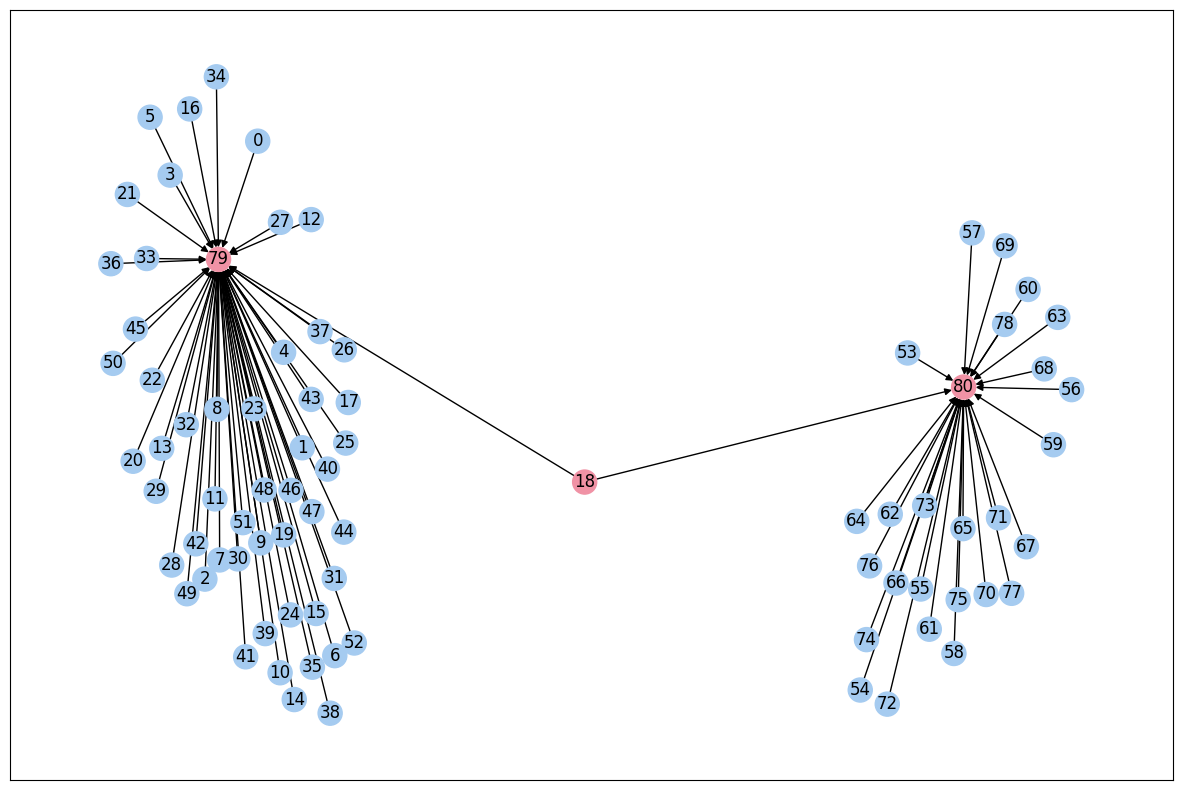

In [11]:
import matplotlib.pyplot as plt
import networkx as nx

g_homogeneous = dgl.to_homogeneous(g)
nxg = g_homogeneous.edge_subgraph(range(80)).to_networkx()

# 색상 지정 (노드 및 에지 유형에 따라 다름)
node_colors = ["#A5CBF0"] * 81
node_colors[18] = node_colors[79] = node_colors[80] = "#F092A5"

# 그래프 시각화
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(nxg, seed=42)  # Fruchterman-Reingold force-directed algorithm을 사용한 레이아웃

nx.draw_networkx(nxg, pos, node_color=node_colors, with_labels=True)
plt.show()

**`train_test_split_by_time`**:
이 함수는 사용자별 시간 순으로 데이터를 정렬하고, 각 사용자의 가장 최근 두 번의 인터랙션을 valdation 및 test 셋으로 구성하는 방식으로, 데이터를 train, val, test 세트로 나누는 함수입니다. "과거를 학습하여 미래를 예측"하는 직관에 기반합니다.

**`build_train_graph`**:
이 함수는 주어진 그래프 'g'에서 train_indices에 포함되는 부분만을 추출하여 subgraph를 생성합니다.

**`build_val_test_matrix`**:
이 함수는 val, test 데이터셋을 표현하는 sparse matrix를 생성합니다. 

In [12]:
# Assign features.
# Note that variable-sized features such as texts or images are handled elsewhere.
g.nodes["user"].data["gender"] = torch.LongTensor(
    users["gender"].cat.codes.values
)
g.nodes["user"].data["age"] = torch.LongTensor(
    users["age"].cat.codes.values
)
g.nodes["user"].data["occupation"] = torch.LongTensor(
    users["occupation"].cat.codes.values
)
g.nodes["user"].data["zip"] = torch.LongTensor(
    users["zip"].cat.codes.values
)

g.nodes["movie"].data["year"] = torch.LongTensor(
    movies["year"].cat.codes.values
)
g.nodes["movie"].data["genre"] = torch.FloatTensor(
    movies[genre_columns].values
)

g.edges["watched"].data["rating"] = torch.LongTensor(
    ratings["rating"].values
)
g.edges["watched"].data["timestamp"] = torch.LongTensor(
    ratings["timestamp"].values
)
g.edges["watched-by"].data["rating"] = torch.LongTensor(
    ratings["rating"].values
)
g.edges["watched-by"].data["timestamp"] = torch.LongTensor(
    ratings["timestamp"].values
)

# Train-validation-test split
# This is a little bit tricky as we want to select the last interaction for test, and the
# second-to-last interaction for validation.
train_indices, val_indices, test_indices = train_test_split_by_time(
    ratings, "timestamp", "user_id"
)

# Build the graph with training interactions only.
train_g = build_train_graph(
    g, train_indices, "user", "movie", "watched", "watched-by"
)
assert train_g.out_degrees(etype="watched").min() > 0

# Build the user-item sparse matrix for validation and test set.
val_matrix, test_matrix = build_val_test_matrix(
    g, val_indices, test_indices, "user", "movie", "watched"
)

## Build title set
movie_textual_dataset = {"title": movies["title"].values}

dataset = {
    "train-graph": train_g,
    "val-matrix": val_matrix,
    "test-matrix": test_matrix,
    "item-texts": movie_textual_dataset,
    "item-images": None,
    "user-type": "user",
    "item-type": "movie",
    "user-to-item-type": "watched",
    "item-to-user-type": "watched-by",
    "timestamp-edge-column": "timestamp",
}

    user_id  movie_id  rating  timestamp  train_mask  val_mask  test_mask
31        1      3186       4  978300019        True     False      False
27        1      1721       4  978300055        True     False      False
37        1      1022       5  978300055        True     False      False
22        1      1270       5  978300055        True     False      False
24        1      2340       3  978300103        True     False      False
36        1      1836       5  978300172        True     False      False
3         1      3408       4  978300275        True     False      False
47        1      1207       4  978300719        True     False      False
7         1      2804       5  978300719        True     False      False
21        1       720       3  978300760        True     False      False
0         1      1193       5  978300760        True     False      False
44        1       260       4  978300760        True     False      False
9         1       919       4  9783013

## Data Loader

In [13]:
import os
import dgl

import evaluation
import layers
import numpy as np
import sampler as sampler_module
import torch
import torch.nn as nn
import torchtext
import tqdm
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

### Prepare dataset

In [14]:
g = dataset["train-graph"]
val_matrix = dataset["val-matrix"].tocsr()
test_matrix = dataset["test-matrix"].tocsr()
item_texts = dataset["item-texts"]
user_ntype = dataset["user-type"]
item_ntype = dataset["item-type"]
user_to_item_etype = dataset["user-to-item-type"]
timestamp = dataset["timestamp-edge-column"]

# 사용자와 아이템 각각에 대해 고유한 ID를 부여하고, 이 ID를 각 노드의 feature로 사용합니다.
# 이 ID는 추후에 각 노드에 대한 embedding을 학습하는 데 사용됩니다.
g.nodes[user_ntype].data["id"] = torch.arange(g.num_nodes(user_ntype))
g.nodes[item_ntype].data["id"] = torch.arange(g.num_nodes(item_ntype))

**`build_vocab_from_iterator`**:
PyTorch의 torchtext 라이브러리에서 제공하는 함수입니다. 이 함수는 반복 가능한 객체(예: 리스트, 제너레이터 등)를 입력으로 받아, 그 안에 등장하는 모든 단어에 대한 어휘(사전)를 구축합니다.어휘는 텍스트 데이터에서 모든 고유한 단어를 모아 놓은 것을 의미하며, 각 단어는 고유한 정수 인덱스에 매핑됩니다. 

In [15]:
# Prepare torchtext dataset and Vocabulary
textset = {}
tokenizer = get_tokenizer(None)

textlist = []
batch_first = True

for i in range(g.num_nodes(item_ntype)):
    for key in item_texts.keys():
        l = tokenizer(item_texts[key][i].lower())
        textlist.append(l)
for key, field in item_texts.items():
    vocab2 = build_vocab_from_iterator(
        textlist, specials=["<unk>", "<pad>"]
    )
    textset[key] = (
        textlist,
        vocab2,
        vocab2.get_stoi()["<pad>"],
        batch_first,
    )

### Sampler

In [16]:
random_walk_length = 2
random_walk_restart_prob = 0.5
num_random_walks = 10
num_neighbors = 3
num_layers = 2

num_epochs = 1
num_workers = 0
batch_size = 32
batches_per_epoch = 20000
lr = 3e-5
k = 10

샘플링 하는 코드를 살펴보면 ItemToItemBatchSample에서 생성된 negative sample이 출발 노드로부터 접근이 가능한 노드가 아니라는 것을 보장하지 않는다. 데이터가 크다면 출발 노드와 negative sample이 중복되는 경우는 비교적 드물 것이다. 이 경우, 간헐적인 중복이 모델의 전반적인 성능에 큰 영향을 미치지 않는다.

위와 같은 사유로 negative sample을 확인하는 절차를 걸치지 않은 것인지 더 알아볼 필요가 있다.

In [47]:
# 출발 노드, 출발 노드로 부터 random_walk를 수행하여 접근 가능한 노드, 출발 노드로부터 도착 불가능한 노드
# 를 반환하는 sampler
batch_sampler = sampler_module.ItemToItemBatchSampler(
    g, user_ntype, item_ntype, batch_size
)

# PinSage의 학습에 필요한 neighbor sampling
# random_walk를 통해 무작위로 노드를 방문하고, 방문을 많이한 노드를 이웃으로 설정
neighbor_sampler = sampler_module.NeighborSampler(
    g,
    user_ntype,
    item_ntype,
    random_walk_length,
    random_walk_restart_prob,
    num_random_walks,
    num_neighbors,
    num_layers,
)

collator = sampler_module.PinSAGECollator(
    neighbor_sampler, g, item_ntype, textset
)

dataloader = DataLoader(
    batch_sampler,
    collate_fn=collator.collate_train,
    num_workers=num_workers,
)

dataloader_test = DataLoader(
    torch.arange(g.num_nodes(item_ntype)),
    batch_size=batch_size,
    collate_fn=collator.collate_test,
    num_workers=num_workers,
)

dataloader_it = iter(dataloader)

## Model

In [ ]:
class PinSAGEModel(nn.Module):
    def __init__(self, full_graph, ntype, textsets, hidden_dims, n_layers):
        super().__init__()

        self.proj = layers.LinearProjector(
            full_graph, ntype, textsets, hidden_dims
        )
        self.sage = layers.SAGENet(hidden_dims, n_layers)
        self.scorer = layers.ItemToItemScorer(full_graph, ntype)

    def forward(self, pos_graph, neg_graph, blocks):
        h_item = self.get_repr(blocks)
        pos_score = self.scorer(pos_graph, h_item)
        neg_score = self.scorer(neg_graph, h_item)
        return (neg_score - pos_score + 1).clamp(min=0)

    def get_repr(self, blocks):
        h_item = self.proj(blocks[0].srcdata)
        h_item_dst = self.proj(blocks[-1].dstdata)
        return h_item_dst + self.sage(blocks, h_item)